In [1080]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

from sklearn.cluster import KMeans

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

#text processing, NLP modules
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA



plt.rcParams['figure.figsize'] = (15, 10)

In [1034]:
#!pip install unidecode

In [1035]:
#!pip install gensim

In [1088]:
df = pd.read_csv("Data/tweety_test.csv")

In [1089]:
df_tweety_full = df

In [1090]:
df_tweety_full

,index,user_name,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day,sentiment,label
0,8,Erin Despas,NaN,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,covid vaccin get,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",2,1,2020-12-12,0,0
1,32,Contagion,"Cranbury, NJ",2016-01-29 15:54:55,5998,815,5867,False,2020-12-12 13:00:00,author unit state last night,"['ICYMI', 'FDA', 'PfizerBioNTech', 'COVID19', ...",0,1,2020-12-12,0,0
2,35,Shahjhan Malik | #WearAMask,"Nottinghamshire, England",2017-06-22 06:22:55,41708,2868,47862,False,2020-12-12 12:42:31,immigr muslim coupl find covid vaccin,"['CovidVaccine', 'PfizerBioNTech', 'Pfizervacc...",2,37,2020-12-12,0,0
3,37,Farooq Anees,"دبي, الامارات العربية المتحدة",2010-12-23 11:51:01,293,319,165,False,2020-12-12 12:20:30,ladi gentleman expert everi household,"['CovidVaccine', 'Pakistan', 'PfizerBioNTech',...",0,0,2020-12-12,0,0
4,38,KHuntson,USA🇺🇸,2014-01-31 01:25:24,2035,1672,6734,False,2020-12-12 12:19:56,fact sheet healthcar provid administ vaccin,"['PfizerBioNTech', 'CovidVaccine']",0,0,2020-12-12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8796,Neha,India,2018-08-30 13:47:20,6592,45,33950,False,2021-02-15 06:19:44,side effect,['Covaxin'],2,6,2021-02-15,0,0
996,8824,Hrushikesha Mohanty,ରହୁରହୁ ହାଇଦରବାଦିଆ,2011-06-12 19:52:56,1591,77,7400,False,2021-02-14 15:11:49,seen covaxin trend twitter let give scientists...,"['JayVigyan', 'Covaxin']",0,8,2021-02-14,1,1
997,8828,Revati,Kerala,2009-09-23 13:59:24,4200,656,27914,False,2021-02-14 11:57:30,got clarif,['Covaxin'],2,10,2021-02-14,0,-1
998,8834,WAM English,UAE,2014-09-04 10:22:21,42764,18,11,True,2021-02-15 09:11:14,approv russia vaccin use,"['Kazakhstan', 'SputnikV', 'WamNews']",0,1,2021-02-15,0,0


In [1134]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['moderna', 'covaxin', 'covid19', 'pfizerbiontech', 'vaccine', 'sputnikv', 'oxfordastrazeneca', 'covidvaccine', 'pfizer', 'sinovac', 'sinopharm', 'covid19vaccine', 'astrazeneca', 'covid', 'coronavirus', 'vaccines', 'china', 'russia', 'covishield', 'vaccination', 'vaccinated', 'pfizervaccine', 'eu', 'india', 'covid_19', 'bharatbiotech', 'covidvaccination', 'covid19vaccination', 'coronavaccine', 'mrna', 'johnsonandjohnson', 'getvaccinated', 'biontech', 'narendramodi', 'hongkong', 'pakistan', 'covidvacccine', 'pmmodi', 'modernavaccine', 'ocgn', 'iran', 'nhs', 'coronavirusvaccine', 'ocugen', 'breaking', 'covidvaccines', 'aiims', 'russian', 'pfizercovidvaccine', 'vaccineswork', 'news', 'putin', 'uk', 'who', 'us', 'canada', 'italy', 'covidー19', 'covid19vaccines', 'israel', 'corona', 'hungary', 'zimbabwe', 'pandemic', 'covax', 'oxfordvaccine', 'usa', 'health', 'modi', 'vaccine', 'first', 'covid', 'dose', 'today', '19', 'vaccines', 'amp', 'shot', 'doses']
stopwords.extend(newStopWords)

In [1135]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [1136]:
def clean_tweet(x):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    x = str(x)
    x = x.lower()

    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub('#[^\s]+','',x)
    #remove URLs
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove punctuation
    x = x.replace('[^\w\s]','')
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z0-9]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #remove linebreaks
    x = re.sub('\n', '', x)
    #remove special characters
    #x = ' '.join(re.findall(r'\w+', x))
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    #stemming
    #x = ' '.join([stemmer.stem(word) for word in x.split() ])
    #lemmatizing
    #x = ' '.join([lemmatizer.lemmatize(word) for word in x.split() ])
    #removing stop words
    x = ' '.join([word for word in x.split() if word not in stopwords])
    #removing numbers
    x = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x)
    #x = x.split()

    return x

In [1137]:
df_tweety_full.text = df_tweety_full.text.apply(lambda x: text_to_word_list(x))

In [1138]:
sentences = [row for row in df_tweety.text]
#phrases = Phrases(sent, min_count=1, progress_per=50000)
#bigram = Phraser(phrases)
#sentences = bigram[sent]

In [1139]:
#sentences

In [1140]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.0 mins


In [1141]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

#w2v_model.init_sims(replace=True)

Time to train the model: 0.01 mins


In [1142]:
w2v_model.save("word2vec.model")

In [1143]:
df_tweety_exp = df_tweety_full.copy()
df_tweety_exp['old_text'] = df_tweety_exp.text
df_tweety_exp.old_text = df_tweety_exp.old_text.str.join(' ')
df_tweety_exp.text = df_tweety_exp.text.apply(lambda x: ' '.join(bigram[x]))
df_tweety_exp.label = df_tweety_exp.label.astype('int8')

In [1144]:
df_tweety_exp

,index,user_name,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day,sentiment,label,old_text
0,8,Erin Despas,NaN,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,vaccin get,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",2,1,2020-12-12,0,0,vaccin get
1,32,Contagion,"Cranbury, NJ",2016-01-29 15:54:55,5998,815,5867,False,2020-12-12 13:00:00,author unit state last_night,"['ICYMI', 'FDA', 'PfizerBioNTech', 'COVID19', ...",0,1,2020-12-12,0,0,author unit state last night
2,35,Shahjhan Malik | #WearAMask,"Nottinghamshire, England",2017-06-22 06:22:55,41708,2868,47862,False,2020-12-12 12:42:31,immigr muslim coupl find vaccin,"['CovidVaccine', 'PfizerBioNTech', 'Pfizervacc...",2,37,2020-12-12,0,0,immigr muslim coupl find vaccin
3,37,Farooq Anees,"دبي, الامارات العربية المتحدة",2010-12-23 11:51:01,293,319,165,False,2020-12-12 12:20:30,ladi gentleman expert everi household,"['CovidVaccine', 'Pakistan', 'PfizerBioNTech',...",0,0,2020-12-12,0,0,ladi gentleman expert everi household
4,38,KHuntson,USA🇺🇸,2014-01-31 01:25:24,2035,1672,6734,False,2020-12-12 12:19:56,fact_sheet healthcar provid administ vaccin,"['PfizerBioNTech', 'CovidVaccine']",0,0,2020-12-12,0,0,fact sheet healthcar provid administ vaccin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8796,Neha,India,2018-08-30 13:47:20,6592,45,33950,False,2021-02-15 06:19:44,side_effect,['Covaxin'],2,6,2021-02-15,0,0,side effect
996,8824,Hrushikesha Mohanty,ରହୁରହୁ ହାଇଦରବାଦିଆ,2011-06-12 19:52:56,1591,77,7400,False,2021-02-14 15:11:49,seen trend twitter let give scientistsbig cred...,"['JayVigyan', 'Covaxin']",0,8,2021-02-14,1,1,seen trend twitter let give scientistsbig cred...
997,8828,Revati,Kerala,2009-09-23 13:59:24,4200,656,27914,False,2021-02-14 11:57:30,got clarif,['Covaxin'],2,10,2021-02-14,0,-1,got clarif
998,8834,WAM English,UAE,2014-09-04 10:22:21,42764,18,11,True,2021-02-15 09:11:14,approv vaccin use,"['Kazakhstan', 'SputnikV', 'WamNews']",0,1,2021-02-15,0,0,approv vaccin use


In [1145]:
df_tweety_exp[['text', 'label']].to_csv('Data/clean_tweety_test.csv', index=False)

# Clustering

In [1146]:
w2v_model.save("word2vec.model")

In [1147]:
word_vectors = Word2Vec.load("word2vec.model").wv

In [1148]:
# Using PCA for Dimensionality Reduction
# And the StandardScaler to scale the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(word_vectors.vectors.astype('double'))
pca_ = PCA(0.99, random_state=0)
X_pca=pca_.fit_transform(X_scaled)

In [1149]:
model = KMeans(n_clusters=3, max_iter=1000, random_state=0, n_init=1000).fit(X_scaled)

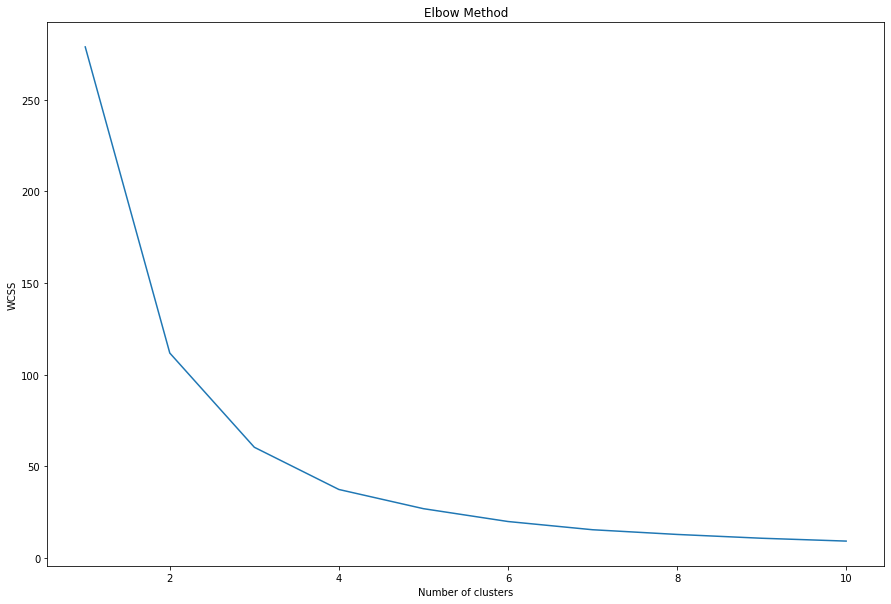

In [1150]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=150, n_init=10, random_state=0)
    kmeans.fit(word_vectors.vectors.astype('double'))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [1160]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=50, restrict_vocab=None)

[('n', 0.8417300581932068),
 ('things', 0.8412624597549438),
 ('firm', 0.84101802110672),
 ('hi', 0.8409554362297058),
 ('halfmillion', 0.840851366519928),
 ('spring', 0.840751588344574),
 ('towards', 0.840727686882019),
 ('superb', 0.8406683206558228),
 ('selling', 0.840650200843811),
 ('awful', 0.8405875563621521),
 ('source', 0.840522050857544),
 ('summary', 0.8404268622398376),
 ('notice', 0.8404076099395752),
 ('woohoo', 0.8403864502906799),
 ('tiredness', 0.8403719067573547),
 ('application', 0.8403641581535339),
 ('sleeping', 0.8403336405754089),
 ('lifted', 0.8403035402297974),
 ('vladimir', 0.8402395844459534),
 ('develop', 0.8401543498039246),
 ('england', 0.840153694152832),
 ('add', 0.8401352763175964),
 ('anxious', 0.8401196599006653),
 ('happening', 0.8401132225990295),
 ('white', 0.8401060104370117),
 ('caused', 0.8400924801826477),
 ('around', 0.8400796055793762),
 ('nice', 0.8400729298591614),
 ('issue', 0.8400523662567139),
 ('definitely', 0.8400329351425171),
 ('forg

In [1161]:
positive_cluster_index = 2
negative_cluster_index = 0
neutral_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[negative_cluster_index]
neutral_cluster_center = model.cluster_centers_[neutral_cluster_index]

In [1162]:
words = pd.DataFrame(word_vectors.key_to_index.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [1163]:
words['cluster_value'] = [(1 if i==positive_cluster_index else (-1 if i==negative_cluster_index else 0)) for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value
#ar = [('four' if i % 4 == 0 else ('six' if i % 6 == 0 else i)) for i in range(1, n)]

In [1164]:
words.head(20)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,vaccine,"[-0.027826933, 0.14891714, 0.2721803, 0.284844...",2,1,0.489833,0.489833
1,first,"[-0.024047554, 0.11684326, 0.20689084, 0.21485...",2,1,0.516199,0.516199
2,dose,"[-0.015674707, 0.098537534, 0.18187377, 0.1896...",2,1,0.498983,0.498983
3,got,"[-0.019914005, 0.09668513, 0.1773002, 0.190162...",2,1,0.497847,0.497847
4,today,"[-0.02030518, 0.10750635, 0.20268033, 0.203601...",2,1,0.510603,0.510603
5,covid,"[-0.021814322, 0.10751459, 0.19423307, 0.20384...",2,1,0.508625,0.508625
6,shot,"[-0.016389197, 0.10352217, 0.19266643, 0.20338...",2,1,0.509686,0.509686
7,second,"[-0.01693805, 0.09885054, 0.17963539, 0.186040...",2,1,0.494619,0.494619
8,get,"[-0.020671612, 0.10331755, 0.1902358, 0.194466...",2,1,0.504964,0.504964
9,vaccinated,"[-0.0132455705, 0.07818043, 0.13839717, 0.1455...",2,1,0.449330,0.449330


In [1165]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [1166]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from IPython.display import display

In [1167]:
final_file = pd.read_csv('Data/clean_tweety_test.csv')

In [1168]:
final_file

,text,label
0,vaccin get,0
1,author unit state last_night,0
2,immigr muslim coupl find vaccin,0
3,ladi gentleman expert everi household,0
4,fact_sheet healthcar provid administ vaccin,0
...,...,...
995,side_effect,0
996,seen trend twitter let give scientistsbig cred...,1
997,got clarif,-1
998,approv vaccin use,0


In [1169]:
sentiment_map = pd.read_csv('sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [1170]:
#sentiment_dict

In [1171]:
file_weighting = final_file.copy()
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.text.astype('U'))
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.text.astype('U'))

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [1172]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.text.split()))

In [1173]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

AttributeError: 'float' object has no attribute 'split'

In [1174]:
replaced_closeness_scores = file_weighting.text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

AttributeError: 'float' object has no attribute 'split'

In [1175]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.text, file_weighting.label]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [(1 if i==1 else (-1 if i==-1 else 0)) for i in replacement_df.sentiment]
words['cluster_value'] = [(1 if i==1 else (-1 if i==-1 else 0)) for i in words.cluster]

replacement_df#.sentiment.value_counts()/len(replacement_df)

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[0, 0]","[3.781620394270129, 5.711530201979001]",vaccin get,0,0.0,0
1,"[0, 0, 0, 0, 0]","[6.810142490647111, 6.810142490647111, 6.81014...",author unit state last_night,0,0.0,0
2,"[0, 0, 0, 0, 0]","[6.810142490647111, 7.215607598755275, 7.21560...",immigr muslim coupl find vaccin,0,0.0,0
3,"[0, 0, 0, 0, 0]","[7.215607598755275, 7.215607598755275, 6.81014...",ladi gentleman expert everi household,0,0.0,0
4,"[0, 0, 0, 0, 0, 0]","[6.810142490647111, 6.810142490647111, 7.21560...",fact_sheet healthcar provid administ vaccin,0,0.0,0
...,...,...,...,...,...,...
995,"[0, 0]","[6.52246041819533, 4.91302250576123]",side_effect,0,0.0,0
996,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[7.215607598755275, 7.215607598755275, 7.21560...",seen trend twitter let give scientistsbig cred...,1,0.0,0
997,"[0, 0]","[4.058607177605162, 7.215607598755275]",got clarif,-1,0.0,0
998,"[0, 0, 0]","[6.29931686688112, 2.383301840183437, 5.962844...",approv vaccin use,0,0.0,0


In [1076]:
replacement_df.sentiment_rate.unique()

array([0.])

In [807]:
y_pred = replacement_df.prediction
y_test = replacement_df.sentiment

In [808]:
conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.sentiment, replacement_df.prediction))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


,0,1,2
0,0,0,118
1,0,2,592
2,0,0,288


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [764]:
conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.sentiment, replacement_df.prediction))
print('Confusion Matrix\n')
print(conf_matrix)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

   0    1  2
0  0  118  0
1  0  594  0
2  0  288  0

Accuracy: 0.59

Micro Precision: 0.59
Micro Recall: 0.59
Micro F1-score: 0.59

Macro Precision: 0.20
Macro Recall: 0.33
Macro F1-score: 0.25

Weighted Precision: 0.35
Weighted Recall: 0.59
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00       118
     Class 2       0.59      1.00      0.75       594
     Class 3       0.00      0.00      0.00       288

    accuracy                           0.59      1000
   macro avg       0.20      0.33      0.25      1000
weighted avg       0.35      0.59      0.44      1000



/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(